In [1]:
import open3d as o3d
import time
import skvideo.io 
import skimage.io
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from pathlib import Path

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)

# Make Scikit-Video happy
np.float = np.float64
np.int = np.int_

# From
# https://medium.com/@nearlydaniel/assertion-of-arbitrary-array-shapes-in-python-3c96f6b7ccb4
from collections import defaultdict
def assert_shape(x, shape:list):
    """ ex: assert_shape(conv_input_array, [8, 3, None, None]) """
    assert len(x.shape) == len(shape), (x.shape, shape)
    for _a, _b in zip(x.shape, shape):
        if isinstance(_b, int):
            assert _a == _b, (x.shape, shape)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


C:\Users\dylan\Documents\Dev\School\Xtractofuse\LightGlue\lightglue\lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
DATA_PATH = Path("data/6070fae025")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to C:\ProgramData\direnv\xdg_home\torch\hub\checkpoints\superpoint_v1.pth
100.0%
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to C:\ProgramData\direnv\xdg_home\torch\hub\checkpoints\superpoint_lightglue_v0-1_arxiv.pth
100.0%


In [6]:
def get_matches(image0: np.ndarray, image1: np.ndarray):

    width = image0.shape[0]
    height = image0.shape[1]

    assert_shape(image1, (width, height, 3))

    image0 = torch.from_numpy(image0.transpose(2, 0, 1))
    image1 = torch.from_numpy(image1.transpose(2, 0, 1))

    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

    return m_kpts0, m_kpts1

(1440, 1920, 3)


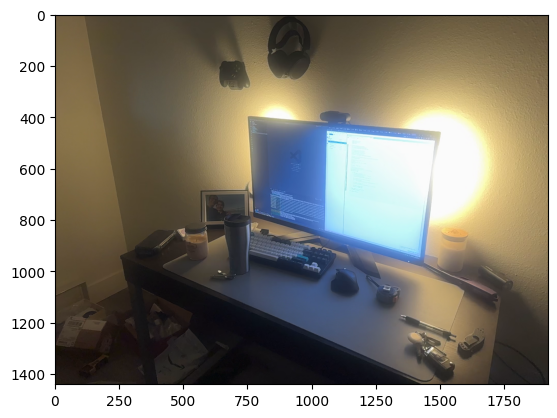

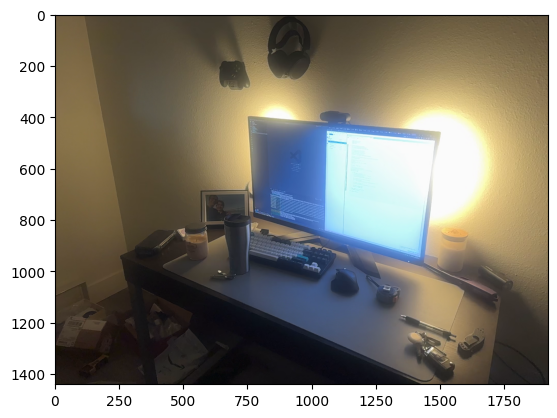

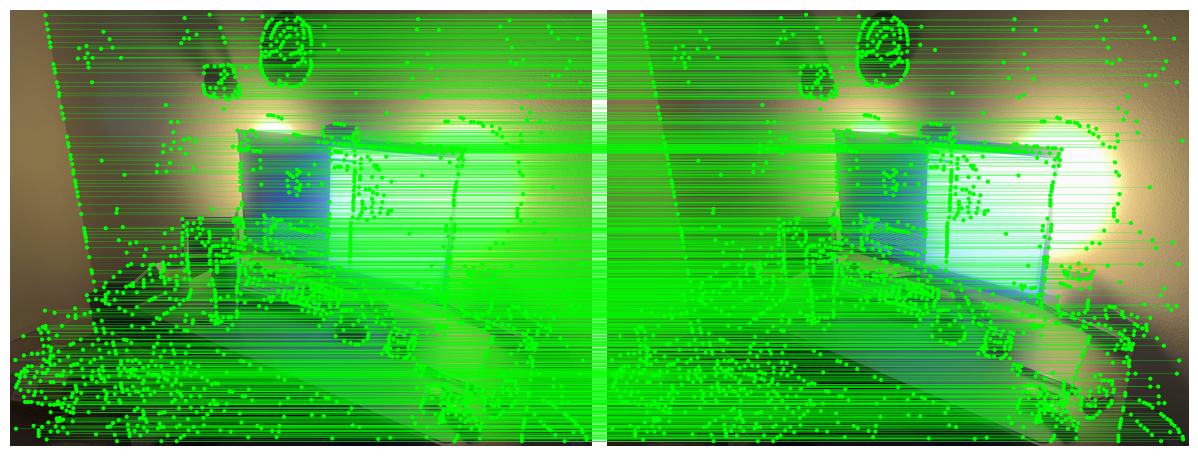

In [32]:
video_data = np.array(list(skvideo.io.vreader(str(DATA_PATH.joinpath("rgb.mp4")))))



video_data = (video_data.astype('float32') / 255.0)

rgb_image = video_data[0]

print(rgb_image.shape)

confidence_image0 = skimage.io.imread(sorted(list(DATA_PATH.glob("confidence/*.png")))[0])
confidence_image0 = skimage.transform.resize(confidence_image0, rgb_image.shape[0:2], order=0)


confidence_image1 = skimage.io.imread(sorted(list(DATA_PATH.glob("confidence/*.png")))[1])
confidence_image1 = skimage.transform.resize(confidence_image1, rgb_image.shape[0:2], order=0)


# new_rgb_image = np.zeros((rgb_image.shape[0], rgb_image.shape[1], 3))

# new_rgb_image[..., 0] = (rgb_image == 0)
# new_rgb_image[..., 1] = (rgb_image == 1)
# new_rgb_image[..., 2] = (rgb_image == 2)

# rgb_image = new_rgb_image * 255
for i in range(len(video_data)):
    plt.imshow(video_data[i])
    plt.show()


np.array_equal(video_data[0], video_data[1])

m_kpts0, m_kpts1 =  get_matches(video_data[0], video_data[1])


axes = viz2d.plot_images([video_data[0], video_data[1]])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)

# kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
# viz2d.plot_images([image0, image1])
# viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

In [8]:
calibration_matrix = np.genfromtxt(DATA_PATH.joinpath("camera_matrix.csv"), delimiter=',')
calibration_matrix

array([[1.3398461e+03, 0.0000000e+00, 9.5837756e+02],
       [0.0000000e+00, 1.3398461e+03, 7.2530835e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

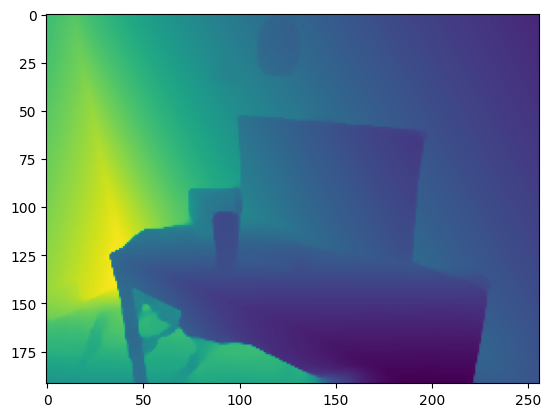

In [9]:
depth_image_paths = sorted(list(DATA_PATH.glob("depth/*.png")))

depth_images = [skimage.io.imread(path) for path in depth_image_paths]

plt.imshow(depth_images[0])

In [10]:
def points_2d_to_3d(points_homogenous_2d: np.ndarray, depths: np.ndarray, calibration_matrix: np.ndarray) -> np.ndarray:

    assert_shape(points_homogenous_2d, (None, 3))

    point_num = len(points_homogenous_2d)

    assert_shape(depths, (point_num, 1))
    assert_shape(calibration_matrix, (3,3))

    # Ray from Point in Image:
    # Ideas from https://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf
    # And https://stackoverflow.com/questions/68249598/how-to-calculate-the-ray-of-a-camera-with-the-help-of-the-camera-matrix

    camera_matrix_inv = np.linalg.inv(calibration_matrix)

    directions = np.matmul(camera_matrix_inv, points_homogenous_2d.T).T
    directions = directions / np.linalg.norm(directions)
    point_cloud = directions * depths # Add Depth info!


    assert_shape(point_cloud, (None, 3))

    return point_cloud[:, 0:3]

def image_to_point_cloud(calibration_matrix: np.array, rgb_image: np.array, depth_map: np.array) -> np.array:
    assert_shape(calibration_matrix, (3,3))

    assert_shape(rgb_image, (None, None, 3))
    height = rgb_image.shape[0]
    width = rgb_image.shape[1]

    assert_shape(depth_map, (None, None))


    xv, yv = np.meshgrid(np.arange(width), np.arange(height))
    all_pixels = np.stack([xv.ravel(), yv.ravel(), np.ones_like(xv).ravel()], axis=1)

    # Upscale depth to the same as our RGB image
    upscaled_depth_image = skimage.transform.resize(depth_map, rgb_image.shape[0:2], order=0)

    point_cloud = points_2d_to_3d(all_pixels, upscaled_depth_image.reshape(-1, 1), calibration_matrix)

    assert_shape(point_cloud, (None, 3))

    return point_cloud

In [44]:
def compute_euclidean_transform_ransac(image0, point_cloud0, image1, point_cloud1, matching_threshold=0.3, iterations=100, confidence_image0=None, confidence_image1=None)-> skimage.transform.EuclideanTransform:
    
    assert_shape(image0, (None, None, 3))
    
    image0_height = image0.shape[0]
    image0_width = image0.shape[1]
    assert_shape(point_cloud0, (image0_height * image0_width, 3))


    assert_shape(image1, (None, None, 3))

    image1_height = image1.shape[0]
    image1_width = image1.shape[1]

    assert_shape(point_cloud1, (image1_height * image1_width, 3))

    if confidence_image0 is None:
        assert confidence_image1 is None
    else:
        assert_shape(confidence_image0, (image0_height, image0_width))
        assert_shape(confidence_image1, (image0_height, image0_width))



    # Shape (None, 2), (None, 2)
    matched_keypoints0, matched_keypoints1 = get_matches(image0, image1)

    # Round to nearest pixel
    matched_keypoints0 = np.round(matched_keypoints0.numpy()).astype(int)
    matched_keypoints1 = np.round(matched_keypoints1.numpy()).astype(int)

    # Turn (x, y) from image coordinates into index into point cloud
    point_cloud0_indices = matched_keypoints0[:, 0] + matched_keypoints0[:, 1] * image0_width
    point_cloud1_indices = matched_keypoints1[:, 0] + matched_keypoints1[:, 1] * image1_width

    print(point_cloud0_indices[0:10])

    # Filter only the high confidence matches
    if confidence_image0 is not None:
        image0_confidence_mask = confidence_image0.flatten() >= 2
        image1_confidence_mask = confidence_image1.flatten() >= 2

        matches_before = len(point_cloud0_indices)

        good_keypoint_matches_mask = (image0_confidence_mask[point_cloud0_indices]) & (image1_confidence_mask[point_cloud1_indices])
        point_cloud0_indices = point_cloud0_indices[good_keypoint_matches_mask]
        point_cloud1_indices = point_cloud1_indices[good_keypoint_matches_mask]

        print(f"Matches before: {matches_before}, Matches after filtering on confidence >= 2: {len(point_cloud0_indices)}")

    # Get the 3D points for the matched keypoints
    matched_point_cloud0 = point_cloud0[point_cloud0_indices]
    matched_point_cloud1 = point_cloud1[point_cloud1_indices]


    best_model = None
    best_inlier_count = 0

    for _ in range(iterations):

        # Get 3 random indices
        random_indices = np.random.choice(len(matched_point_cloud0), 3)

        model = skimage.transform.EuclideanTransform()
        model.estimate(matched_point_cloud0[random_indices], matched_point_cloud1[random_indices])

        transformed_points = model(matched_point_cloud0)

        # Get inliers under threshold
        error = np.sqrt(np.sum((transformed_points - matched_point_cloud1)**2, axis=1))

        inlier_count = np.count_nonzero(error < matching_threshold)

        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_model = model
    
    return best_model

    
compute_euclidean_transform_ransac(video_data[0], image_to_point_cloud(calibration_matrix, rgb_image, depth_images[0]), video_data[1], image_to_point_cloud(calibration_matrix, rgb_image, depth_images[1]), confidence_image0=confidence_image0, confidence_image1=confidence_image1)


[29459 32757 41153 48949 52416 58367 58465 58514 58559 58947]
Matches before: 1755, Matches after filtering on confidence >= 2: 951


<EuclideanTransform(matrix=
    [[ 9.99999179e-01, -2.93045722e-04, -1.24763483e-03,  1.11450903e-03],
     [ 2.94225081e-04,  9.99999510e-01,  9.45197064e-04, -9.05727440e-04],
     [ 1.24735724e-03, -9.45563373e-04,  9.99998775e-01,  6.38055542e-04],
     [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]) at 0x1e49c7b2650>

In [41]:
def add_point_cloud_to_viz(point_cloud, rgb_image, vis):
    colors = rgb_image.reshape(-1,3)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    vis.add_geometry(pcd)

In [64]:
point_cloud0 = image_to_point_cloud(calibration_matrix, video_data[0], depth_images[0])

point_cloud1 = image_to_point_cloud(calibration_matrix, video_data[1], depth_images[1])

point_cloud0 = point_cloud0
point_cloud1 = point_cloud1

model = compute_euclidean_transform_ransac(video_data[0], point_cloud0, 
                                           video_data[1], point_cloud1, 
                                           matching_threshold=0.1, iterations=1000,
                                           confidence_image0=confidence_image0,
                                           confidence_image1=confidence_image1)

point_cloud0 = model(point_cloud0)

# Filter based on confidence
point_cloud0 = point_cloud0[confidence_image0.flatten() >= 2]
point_cloud1 = point_cloud1[confidence_image1.flatten() >= 2]


filtered_video_data0 = video_data[0][confidence_image0 >= 2]
filtered_video_data1 = video_data[1][confidence_image1 >= 2]

# print(point_cloud.shape)


# create visualizer and window.
vis = o3d.visualization.Visualizer()
vis.create_window(height=480, width=640)

add_point_cloud_to_viz(point_cloud0, filtered_video_data0, vis)
add_point_cloud_to_viz(point_cloud1, filtered_video_data1, vis)

# run non-blocking visualization. 
# To exit, press 'q' or click the 'x' of the window.
keep_running = True
while keep_running:
    keep_running = vis.poll_events()
    vis.update_renderer()

vis.destroy_window()

[29459 32757 41153 48949 52416 58367 58465 58514 58559 58947]
Matches before: 1755, Matches after filtering on confidence >= 2: 951


In [65]:

import os
import numpy as np
from PIL import Image
import argparse
np.float, np.int = np.float64, np.int_
import open3d as o3d
from plyfile import PlyData, PlyElement
import subprocess

DEPTH_WIDTH = 256
DEPTH_HEIGHT = 192
MAX_DEPTH = 20.0

def extract_frames(video_path, frame_dir):
    os.makedirs(frame_dir, exist_ok=True)
    
    subprocess.run([
        'ffmpeg', '-i', video_path, '-vsync', 'vfr', '-q:v', '1', '-start_number', '0',
        os.path.join(frame_dir, '%06d.png')
    ])


def quaternion_to_rotation_matrix(quaternion):
    qx, qy, qz, qw = quaternion
    return np.array([
        [1 - 2 * (qy**2 + qz**2), 2 * (qx * qy - qz * qw), 2 * (qx * qz + qy * qw)],
        [2 * (qx * qy + qz * qw), 1 - 2 * (qx**2 + qz**2), 2 * (qy * qz - qx * qw)],
        [2 * (qx * qz - qy * qw), 2 * (qy * qz + qx * qw), 1 - 2 * (qx**2 + qy**2)]
    ])

def get_intrinsics(data):
    fx = data['intrinsics'][0, 0]
    fy = data['intrinsics'][1, 1]
    cx = data['intrinsics'][0, 2]
    cy = data['intrinsics'][1, 2]
    return np.array([[fx * DEPTH_WIDTH / 1920, 0, cx * DEPTH_WIDTH / 1920],
                     [0, fy * DEPTH_HEIGHT / 1440, cy * DEPTH_HEIGHT / 1440],
                     [0, 0, 1]])

def create_point_cloud(rgbd, intrinsics, T_CW):
    rgb, depth = rgbd
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]

    points, colors = [], []
    for v in range(depth.shape[0]):
        for u in range(depth.shape[1]):
            z = depth[v, u]
            if z > 0 and z < MAX_DEPTH:
                x = (u - cx) * z / fx
                y = (v - cy) * z / fy
                point_world = T_CW[:3, :3] @ np.array([x, y, z]) + T_CW[:3, 3]
                points.append(point_world)
                colors.append(rgb[v, u] / 255.0)
    return np.array(points), np.array(colors)

def accumulate_point_cloud(pc, rgbd, intrinsics, T_CW):
    points, colors = create_point_cloud(rgbd, intrinsics, T_CW)
    pc[0].extend(points)
    pc[1].extend(colors)

def save_point_cloud_to_ply(filename, points, colors):
    vertices = [(points[i, 0], points[i, 1], points[i, 2],
             int(colors[i, 0] * 255), int(colors[i, 1] * 255), int(colors[i, 2] * 255))
            for i in range(points.shape[0])]
    ply_data = PlyElement.describe(
        np.array(vertices, dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
                                ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]),
        'vertex')
    PlyData([ply_data]).write(filename)

def visualize_point_cloud(points, colors):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd])

def process_point_clouds(args, data):
    intrinsics = get_intrinsics(data)
    pc = ([], [])
    video_path = os.path.join(args.path, 'rgb.mp4')
    frame_dir = os.path.join(args.path, 'frames')
    
    if not os.path.exists(frame_dir):
        extract_frames(video_path, frame_dir)

    for i, T_WC in enumerate(data['poses']):
        if i % args.every != 0:
            continue
        print(f"Point cloud {i}", end="\r")
        T_CW = np.linalg.inv(T_WC)
        confidence = np.array(Image.open(os.path.join(args.path, 'confidence', f'{i:06}.png')))
        depth_path = data['depth_frames'][i]
        depth_m = np.array(Image.open(depth_path)).astype(np.float32) / 1000.0
        depth_m[confidence < args.confidence] = 0.0
        
        rgb_frame_path = os.path.join(frame_dir, f'{i:06}.png')
        rgb_frame = np.array(Image.open(rgb_frame_path))
        rgbd = (np.array(Image.fromarray(rgb_frame).resize((DEPTH_WIDTH, DEPTH_HEIGHT))), depth_m)
        
        accumulate_point_cloud(pc, rgbd, intrinsics, T_WC)

    points, colors = np.array(pc[0]), np.array(pc[1])
    visualize_point_cloud(points, colors)
    save_point_cloud_to_ply("output.ply", points, colors)

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('path', type=str)
    parser.add_argument('--every', type=int, default=1)
    parser.add_argument('--confidence', type=int, default=1)
    args = parser.parse_args()

    intrinsics = np.loadtxt(os.path.join(DATA_PATH, 'camera_matrix.csv'), delimiter=',')
    odometry = np.loadtxt(os.path.join(DATA_PATH, 'odometry.csv'), delimiter=',', skiprows=1)
    poses = []

    for line in odometry:
        position, quaternion = line[2:5], line[5:]
        T_WC = np.eye(4)
        T_WC[:3, :3] = quaternion_to_rotation_matrix(quaternion)
        T_WC[:3, 3] = position
        poses.append(T_WC)

    depth_dir = os.path.join(args.path, 'depth')
    depth_frames = [os.path.join(depth_dir, p) for p in sorted(os.listdir(depth_dir))]

    process_point_clouds(args, {'poses': poses, 'intrinsics': intrinsics, 'depth_frames': depth_frames})
 
